In [88]:
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

import random


In [89]:
king_county_data = pd.read_csv('king_county_data_geocoded.csv') #, nrows=500)
king_county_data.head()

,AppraisedValue,SqFtLot,WaterSystem,SewerSystem,Access,Topography,StreetSurface,RestrictiveSzShape,InadequateParking,PcntUnusable,...,NativeGrowthProtEsmt,Easements,OtherDesignation,DeedRestrictions,DevelopmentRightsPurch,WaterProblems,TranspConcurrency,OtherProblems,lat,long
0,619000.0,6542712,1,1,4,0,1,0,0,0,...,0,0,0,0,1,0,0,0,47.354019,-122.225166
1,708000.0,105850,2,1,3,0,2,0,0,0,...,0,0,0,0,0,0,0,0,47.611248,-122.053154
2,297000.0,1667,2,2,4,0,1,0,2,0,...,0,0,0,0,0,0,0,0,47.701248,-122.365784
3,523000.0,1872,2,2,4,0,1,0,2,0,...,0,0,0,0,0,0,0,0,47.537918,-122.392845
4,288000.0,3480,2,2,4,0,1,0,0,0,...,0,0,0,0,0,0,0,0,47.510227,-122.182167


In [90]:
prices = king_county_data['AppraisedValue']
initial_houses = king_county_data[['lat', 'long', 'SqFtLot']]
houses = (initial_houses - initial_houses.mean()) / (initial_houses.max() - initial_houses.min())
houses.head(10)

,lat,long,SqFtLot
0,-0.002242,-0.002462,0.926671
1,0.004307,-0.001409,0.012226
2,0.006598,-0.003323,-0.002574
3,0.002440,-0.003489,-0.002545
4,0.001735,-0.002199,-0.002317
5,-0.002218,-0.002500,0.074805
6,0.006545,-0.002801,-0.001785
7,0.006547,-0.002318,-0.001105
8,0.007338,-0.003263,-0.002667
9,-0.054704,0.170928,-0.002577


In [91]:
class Regression:
    def __init__(self, values, results):
        self.values = values
        self.results = results
        self.neigh = NearestNeighbors(n_neighbors=5)
        self.neigh.fit(self.values) 
        
    def regress(self, query_point):
        _, indexes = self.neigh.kneighbors([query_point])
        query_price = np.mean(self.results.iloc[indexes[0]])
        if (np.isnan(query_price)):
            raise Exception('Unexpected result')
        return query_price 


r = Regression(houses, prices)
r.regress([0.1, 0.1, 0.8])

733800.0

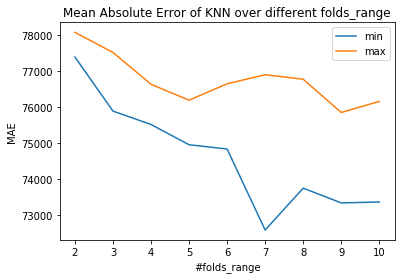

In [92]:
def test(folds, data, values):
    
    errors = []
    for _ in range(folds):
        test_rows = random.sample(data.index.tolist(), int(len(data) / float(folds)))
        train_rows = list(set(range(len(data))) - set(test_rows))

        test_data = data.iloc[test_rows]
        train_data = data.iloc[train_rows]
        train_values = values.iloc[train_rows]

        r = Regression(train_data, train_values)

        values_regr = []
        values_actual = []

        for idx, row in test_data.iterrows():
            values_regr.append(r.regress(row))
            values_actual.append(values.iloc[idx])

        errors.append(mean_absolute_error(values_regr, values_actual))
            
    return errors

folds_range = range(2, 11)
errors_df = pd.DataFrame({'min': 0, 'max': 0}, index=folds_range)
for folds in folds_range:
    errors = test(folds, houses, prices)
    errors_df['max'][folds] = max(errors)
    errors_df['min'][folds] = min(errors)
errors_df.plot(title='Mean Absolute Error of KNN over different folds_range')
plt.xlabel('#folds_range')
plt.ylabel('MAE')
plt.show()